Parse metadata text file and extract basin information.

In [2]:
meta = open('../raw_Illumina_data/sample_metadata/Sample_metadata.csv', 'r')

headers = meta.next().split(',')

basins = {}

for l in meta:
    if l.startswith('Winder'):
        basin = l.split(',')[3].split(" ")[3]
        if basin == 'N':
            basin = 'North'
        elif basin == 'S':
            basin = 'South'
        basins[l.split(',')[0]] = basin
        
print basins

meta.close()

{'Windermere_11-10m': 'North', 'Windermere_28-10m': 'South', 'Windermere_01': 'North', 'Windermere_02': 'North', 'Windermere_03': 'North', 'Windermere_04': 'North', 'Windermere_05': 'North', 'Windermere_06': 'North', 'Windermere_07': 'North', 'Windermere_08': 'North', 'Windermere_09': 'North', 'Windermere_20': 'South', 'Windermere_21': 'South', 'Windermere_26': 'South', 'Windermere_27': 'South', 'Windermere_11-60m': 'North', 'Windermere_25': 'South', 'Windermere_47': 'North', 'Windermere_11-50m': 'North', 'Windermere_40': 'South', 'Windermere_44': 'North', 'Windermere_11-40m': 'North', 'Windermere_28-0m': 'South', 'Windermere_11-0m': 'North', 'Windermere_24': 'South', 'Windermere_29': 'South', 'Windermere_36': 'South', 'Windermere_41': 'South', 'Windermere_45': 'North', 'Windermere_22': 'South', 'Windermere_17': 'South', 'Windermere_16': 'South', 'Windermere_15': 'North', 'Windermere_11-30m': 'North', 'Windermere_13': 'North', 'Windermere_12': 'North', 'Windermere_10': 'North', 'Winder

Import BIOM table python functions.

In [3]:
from biom.table import Table

Define a few helpful functions.

In [55]:

#Parse BIOM table
def parse_BIOM_denovo(table):

    from biom.table import Table
    import json

    with open(table) as data_file:
        data = json.load(data_file)
    t = Table.from_json(data)

    return t

#Plot BIOM table as heatmap
def plot_BIOM_as_heatmap(BIOM, width_in=5, target_png=None):

    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
#    %matplotlib inline
    #%pylab inline

    column_labels = BIOM.ids('observation')
    row_lables = BIOM.ids('sample')
    data = []

    for o in column_labels:

         data.append(BIOM.data(o,axis='observation'))
    
    data = np.asarray(data)

    # Plot it out
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=plt.cm.Reds, alpha=0.8)

    # Format
    fig = plt.gcf()
    fig.set_size_inches(width_in,8)

    # turn off the frame
    ax.set_frame_on(False)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(row_lables, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    # rotate the
    plt.xticks(rotation=90)

    ax.grid(False)

    # Turn off all the ticks
    ax = plt.gca()

    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
        
    #write to file
    if target_png:
        fig.savefig(target_png, dpi=100)
        
        
#Write BIOM table to file
def write_BIOM(BIOM, target_file):

    
    out=open(target_file+".biom","w")
    BIOM.to_json('metaBEAT v.0.96', direct_io=out)
    out.close()

    out=open(target_file+".tsv","w")
    out.write(BIOM.to_tsv(header_key='taxonomy', header_value='taxomomy'))
    out.close()
    
def find_target(BIOM, target):
    
    samples = BIOM.ids('sample')
    positives = BIOM.norm(axis='sample').data(target,'observation')
    
    index=0
    for o in positives:
#        print o
        if str(o) != '0.0':
            print "%s\t(%.4f %%)" %(samples[index],o)
        index+=1

Specify BIOM result tables from each method.

In [5]:
per_method_files = {'blast':'../.././../metabarcode-course-2016/data/exercise-5/results_backup/BLAST_0.85/all_3-by-taxonomy-readcounts.blast.biom',
                   'pplacer':'../../../metabarcode-course-2016/data/exercise-5/results_backup/PPLACER/all_3-by-taxonomy-readcounts.pplacer.biom',
                   'kraken':'../../../metabarcode-course-2016/data/exercise-5/results_backup/KRAKEN/all_3-by-taxonomy-readcounts.kraken.biom'}

Add metadata to tables:

 - method
 - Basin
 - method+Basin
 
 

In [10]:
Tables = {}
for method in per_method_files:
    ##Parse Table from BIOM
    Tables[method] = parse_BIOM_denovo(per_method_files[method])
    #define metadata
    sample_metadata = {}
    samples = Tables[method].ids()
    for q in samples:
        print "adding metadata to: %s" %q
        sample_metadata[q] = {}
        sample_metadata[q]['method'] = method
        sample_metadata[q]['basin'] = basins[q]
        sample_metadata[q]['method+basin'] = method+'+'+basins[q]

    #add metadata to individual table
    Tables[method].add_metadata(sample_metadata, axis='sample')
    #add method suffix to sample name
    rename = {}
    for i in range(len(samples)):
        rename[samples[i]] = samples[i]+'.'+method
    Tables[method].update_ids(rename, axis='sample')
    #produce normalized tables
    Tables[method+'_norm'] = Tables[method].norm(axis='sample', inplace=False)
    #produce convert to presentse absence table
    Tables[method+'_pa'] = Tables[method].pa(inplace=False)

adding metadata to: Windermere_01
adding metadata to: Windermere_02
adding metadata to: Windermere_03
adding metadata to: Windermere_04
adding metadata to: Windermere_05
adding metadata to: Windermere_06
adding metadata to: Windermere_07
adding metadata to: Windermere_08
adding metadata to: Windermere_09
adding metadata to: Windermere_10
adding metadata to: Windermere_11-0m
adding metadata to: Windermere_11-10m
adding metadata to: Windermere_11-20m
adding metadata to: Windermere_11-30m
adding metadata to: Windermere_11-40m
adding metadata to: Windermere_11-50m
adding metadata to: Windermere_11-60m
adding metadata to: Windermere_12
adding metadata to: Windermere_13
adding metadata to: Windermere_14
adding metadata to: Windermere_15
adding metadata to: Windermere_16
adding metadata to: Windermere_17
adding metadata to: Windermere_18
adding metadata to: Windermere_19
adding metadata to: Windermere_20
adding metadata to: Windermere_21
adding metadata to: Windermere_22
adding metadata to: W

Merge all tables.

Create merged table containing read counts.

In [13]:
methods = per_method_files.keys()
Tables['merged'] = []
Tables['merged'] = Tables[methods[0]]
for i in range(1,len(methods)):
    Tables['merged'] = Tables['merged'].merge(Tables[methods[i]])

Write table to file - see [here](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/blob/master/data/exercise-5/results_backup/Merged_readcounts.tsv)

Also try to load the biom files in the `./results_backup` directory.

In [17]:
write_BIOM(BIOM=Tables['merged'], target_file='Merged_readcounts')

Create merged table with present/absence data.

In [18]:
methods = per_method_files.keys()
Tables['merged_pa'] = []
Tables['merged_pa'] = Tables[methods[0]+'_pa']
for i in range(1,len(methods)):
    Tables['merged_pa'] = Tables['merged_pa'].merge(Tables[methods[i]+'_pa'])

Collapse table by method.

In [20]:
bin_f = lambda if_, x: x['method']

In [21]:
#site occupancy
Tables['collapsed_by_method_count'] = Tables['merged_pa'].collapse(bin_f, norm=False, min_group_size=1, axis='sample')
#proportion of sites
Tables['collapsed_by_method_prop'] = Tables['merged_pa'].collapse(bin_f, norm=True, min_group_size=1, axis='sample')

Write tables to file. 

See Table summarizing the number of sites taxa were found in across assignment approaches [here](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/blob/master/data/exercise-5/results_backup/Per_method_site_count.tsv).

See relative proportion of sites at which species were detected by each method [here](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/blob/master/data/exercise-5/results_backup/Per_method_site_prop.tsv).

In [27]:
write_BIOM(BIOM=Tables['collapsed_by_method_count'], target_file='Per_method_site_count')
write_BIOM(BIOM=Tables['collapsed_by_method_prop'], target_file='Per_method_site_prop')


Collapse table by method+basin.

In [24]:
bin_f = lambda if_, x: x['method+basin']

In [26]:
Tables['collapsed_by_method+basin_count']= \
    Tables['merged_pa'].collapse(bin_f, norm=False, min_group_size=1, axis='sample').sort_order\
    (['blast+North','pplacer+North','kraken+North','blast+South','pplacer+South','kraken+South'])

Tables['collapsed_by_method+basin_prop']= \
    Tables['merged_pa'].collapse(bin_f, norm=True, min_group_size=1, axis='sample').sort_order\
    (['blast+North','pplacer+North','kraken+North','blast+South','pplacer+South','kraken+South'])
       
       

Write tables.

In [29]:
write_BIOM(BIOM=Tables['collapsed_by_method+basin_count'], target_file='Per_method_and_basin_site_count')
write_BIOM(BIOM=Tables['collapsed_by_method+basin_prop'], target_file='Per_method_and_basin_site_prop')

Plot heatmaps.

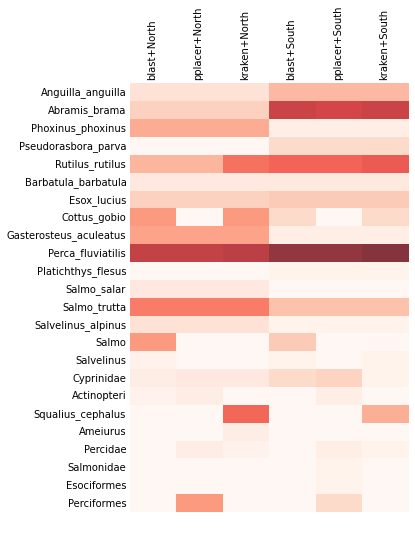

In [52]:

plot_BIOM_as_heatmap(BIOM=Tables['collapsed_by_method+basin_prop'].filter(['unassigned'], 
                inplace=False, axis='observation',invert=True), target_png='Per_method_and_basin_site_prop.heatmap.png')

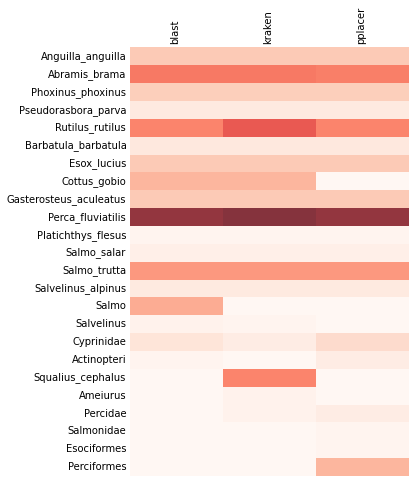

In [53]:
plot_BIOM_as_heatmap(Tables['collapsed_by_method_prop'].filter(['unassigned'], inplace=False, axis='observation',invert=True))

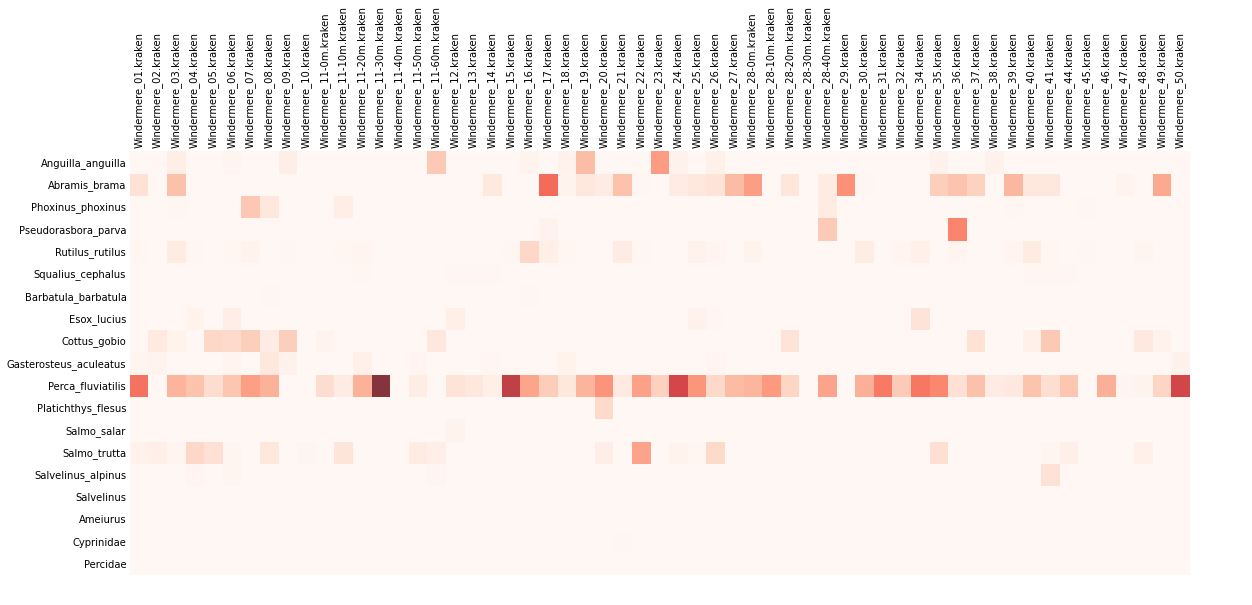

In [54]:
plot_BIOM_as_heatmap(Tables['kraken_norm'].filter(['unassigned'],axis='observation', inplace=False, invert=True), width_in=20)

Find species samples in which a target species was identified.

In [56]:
find_target(target='Anguilla_anguilla', BIOM=Tables['blast'])

Windermere_03.blast	(0.0501 %)
Windermere_06.blast	(0.0116 %)
Windermere_09.blast	(0.0504 %)
Windermere_11-60m.blast	(0.2023 %)
Windermere_16.blast	(0.0251 %)
Windermere_18.blast	(0.0372 %)
Windermere_19.blast	(0.2381 %)
Windermere_21.blast	(0.0006 %)
Windermere_23.blast	(0.3255 %)
Windermere_24.blast	(0.0309 %)
Windermere_26.blast	(0.0403 %)
Windermere_35.blast	(0.0287 %)
Windermere_38.blast	(0.0345 %)


In [57]:
find_target(target='Salmo_trutta', BIOM=Tables['blast'])

Windermere_01.blast	(0.0297 %)
Windermere_02.blast	(0.0387 %)
Windermere_03.blast	(0.0118 %)
Windermere_04.blast	(0.1174 %)
Windermere_05.blast	(0.0893 %)
Windermere_06.blast	(0.0114 %)
Windermere_08.blast	(0.0793 %)
Windermere_10.blast	(0.0118 %)
Windermere_11-0m.blast	(0.0026 %)
Windermere_11-10m.blast	(0.0851 %)
Windermere_11-50m.blast	(0.0500 %)
Windermere_11-60m.blast	(0.0487 %)
Windermere_17.blast	(0.0025 %)
Windermere_20.blast	(0.0352 %)
Windermere_22.blast	(0.2534 %)
Windermere_24.blast	(0.0132 %)
Windermere_25.blast	(0.0055 %)
Windermere_26.blast	(0.1104 %)
Windermere_35.blast	(0.1074 %)
Windermere_41.blast	(0.0101 %)
Windermere_44.blast	(0.0369 %)
Windermere_45.blast	(0.0032 %)
Windermere_48.blast	(0.0272 %)
